Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

 http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from bisect import bisect_left
np.set_printoptions(threshold = np.inf)

# Implementation of High Dimensional Generalized Staircase Mechanism
The implementation of generalized staricase mechanism in $d$ dimensions with a given $\gamma$ and pure differential privacy budget $\varepsilon$ has the following steps:


1.   Sample x from the Discrete Gamma distribution defined in the paper $D\Gamma()$
2.   Sample y from the given unit norm ball of shape $K$.

Note that step (1) and (2) are independent of each other.



In [ ]:
def DiscreteGammaDistribution(gamma, d, epsilon):
  result = - 1
  while result < 0:
    dice = 0.0
    for _ in range(d):
      dice += abs(np.random.laplace(scale=1.0 / epsilon))
    term = math.ceil(dice - gamma)
    assert term >= 0
    remainder = term + gamma - dice
    assert 0 <= remainder <= 1
    last_dice = abs(np.random.laplace(scale = 1.0 / epsilon))
    if last_dice >= remainder:
      result = term + math.floor(last_dice - remainder)
  return result

def ContinuousGammaDistribution(d, epsilon):
  return sum([abs(np.random.laplace(scale=1.0 / epsilon)) for _ in range(d+1)])

"""
Oracle used to uniformly sample from K. Currenly support three types for K, relatively ell_{1,2,inf} unit balls.
"""
def UniformSample(norm_type, d):
  assert norm_type in ["ell_1", "ell_2", "ell_inf"]

  if norm_type == "ell_1":
    points = [0.0] + [np.random.uniform() for _ in range(d)]
    points.sort()
    signs = 2 * np.random.binomial(1, 0.5, d) - 1
    return np.multiply(signs, np.array([points[i+1] - points[i] for i in range(d)]))

  elif norm_type == "ell_2":
    x = np.random.normal(size=d)
    x = x / np.linalg.norm(x)
    return np.random.uniform() ** (1.0 / d) * x

  elif norm_type == "ell_inf":
    signs = 2 * np.random.binomial(1, 0.5, d) - 1
    return np.multiply(signs, np.random.uniform(size=d))

"""
Returns the error with one of ell_{1,2,inf} norms.
"""
def MetricEval(x, norm_type):
  assert norm_type in ["ell_1", "ell_2", "ell_inf"]
  if norm_type == "ell_1":
    return sum(np.abs(x))
  elif norm_type == "ell_2":
    return np.linalg.norm(x)
  elif norm_type == "ell_inf":
    return max(abs(x))


For experiments, we always use the $\gamma^*$ value that is known to give the optimal generalized staircase mechanism for when the target metric norm matches the given shape $K$. There is no closed-form expression for this value, hence we find it by binary searching over $[0,1]$ to find the $\gamma^*$ which makes the derivative of expected error metric value zero with respect to $\gamma$.

In [ ]:
def ComputeConst(gamma, d, epsilon):
  C = 0.0
  for i in range(100000):
    term = (i + gamma) ** d * math.exp(-epsilon * i)
    C += term
  return C

def ComputeError(gamma, d, epsilon):
  return d * ComputeConst(gamma, d + 1, epsilon) / ((d + 1) * ComputeConst(gamma, d, epsilon))

def ComputeDerivative(gamma, d, epsilon):
  if d == 0:
    return 0.0
  x = ComputeConst(gamma, d, epsilon)
  y = ComputeConst(gamma, d+1, epsilon)
  assert y > 0, "y out of range"
  z = ComputeConst(gamma, d-1, epsilon)
  assert z > 0, "z out of range"
  return ((d+1) * x ** 2 - d * y * z) / x ** 2

def ComputeOptimalGamma(d, epsilon, method="binary"):
  assert method in ["binary", "grid"]
  if method == "binary":
    gamma_upper = 1.0
    gamma_lower = math.exp(-epsilon / d)
    val_upper = ComputeDerivative(gamma_upper, d, epsilon)
    val_lower = ComputeDerivative(gamma_lower, d, epsilon)
    assert(val_upper >= 0.0 and val_lower <= 0.0), "Gamma range not right"
    middle = (gamma_upper + gamma_lower) / 2.0
    val = ComputeDerivative(middle, d, epsilon)
    while gamma_upper - gamma_lower > 1e-4:
      if val > 0:
        gamma_upper = middle
      else:
        gamma_lower = middle
      middle = (gamma_upper + gamma_lower) / 2.0
      val = ComputeDerivative(middle, d, epsilon)
    return middle
  elif method == "grid":
    gamma_list = np.linspace(0, 1, 101)
    minimum = math.inf
    gamma_star = None
    for gamma in gamma_list:
      error = ComputeError(gamma, d, epsilon)
      if error < minimum:
        minimum = error
        gamma_star = gamma
    return gamma_star

In [ ]:
def DiscreteKNorm(d, epsilon, gamma, norm_type="ell_1"):
  i = DiscreteGammaDistribution(gamma, d, epsilon)
  return (i + gamma) * UniformSample(norm_type, d)

def ContinuousKNorm(d, epsilon, norm_type="ell_1"):
  x = ContinuousGammaDistribution(d, epsilon)
  return x * UniformSample(norm_type, d)


In [ ]:
dims = [1, 2, 3, 4, 5, 6, 7, 8]
eps_list = [2 ** i for i in range(-2, 6)]
gamma_list, discrete_errors, continuous_errors = np.zeros((len(dims), len(eps_list))), np.zeros((len(dims), len(eps_list))), np.zeros((len(dims), len(eps_list)))
for i, d in enumerate(dims):
  print(f"====== d={d} =======")
  for j, eps in enumerate(eps_list):
    print("eps: ", eps)
    gamma_s = ComputeOptimalGamma(d, eps, method="grid")
    gamma_list[i][j] = gamma_s

    discrete_error = ComputeError(gamma_s, d, eps)
    discrete_errors[i][j] = discrete_error
    print("Discrete: ", discrete_error)

    print("Continuous: ")
    continuous_errors[i][j] = float(d / eps)
    print(float(d / eps))


====== d=1 =======
eps:  0.25
Discrete:  3.9896024740579588
Continuous: 
4.0
eps:  0.5
Discrete:  1.9793187770005465
Continuous: 
2.0
eps:  1
Discrete:  0.9595205193558366
Continuous: 
1.0
eps:  2
Discrete:  0.4254603777683866
Continuous: 
0.5
eps:  4
Discrete:  0.1378625734049228
Continuous: 
0.25
eps:  8
Discrete:  0.01842149589834912
Continuous: 
0.125
eps:  16
Discrete:  0.005005682964275934
Continuous: 
0.0625
eps:  32
Discrete:  0.005000000000639541
Continuous: 
0.03125
====== d=2 =======
eps:  0.25
Discrete:  7.999028225573031
Continuous: 
8.0
eps:  0.5
Discrete:  3.9962465728523586
Continuous: 
4.0
eps:  1
Discrete:  1.9861550362603562
Continuous: 
2.0
eps:  2
Discrete:  0.9545638542526171
Continuous: 
1.0
eps:  4
Discrete:  0.38814350600831893
Continuous: 
0.5
eps:  8
Discrete:  0.09134053191756984
Continuous: 
0.25
eps:  16
Discrete:  0.007431104007868271
Continuous: 
0.125
eps:  32
Discrete:  0.006666666752791437
Continuous: 
0.0625
====== d=3 =======
eps:  0.25
Discrete:  1

# Comparison between generalized staircase and vanilla K-norm



## Synthesized data using conventional K shapes

Generalized staircase mechanism's error v.s. that of vanilla K-norm, when measured using the matching target norm $\| \cdot \|_K$ (this value is independent of K), as $\varepsilon$ changes:

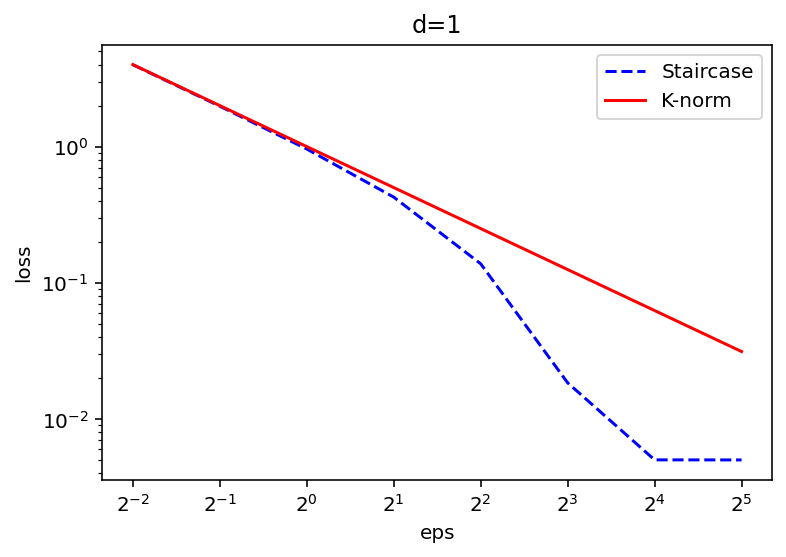

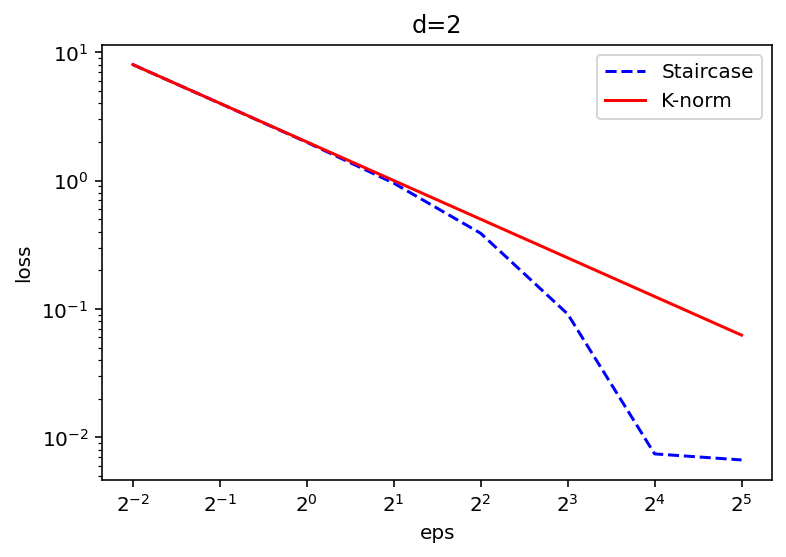

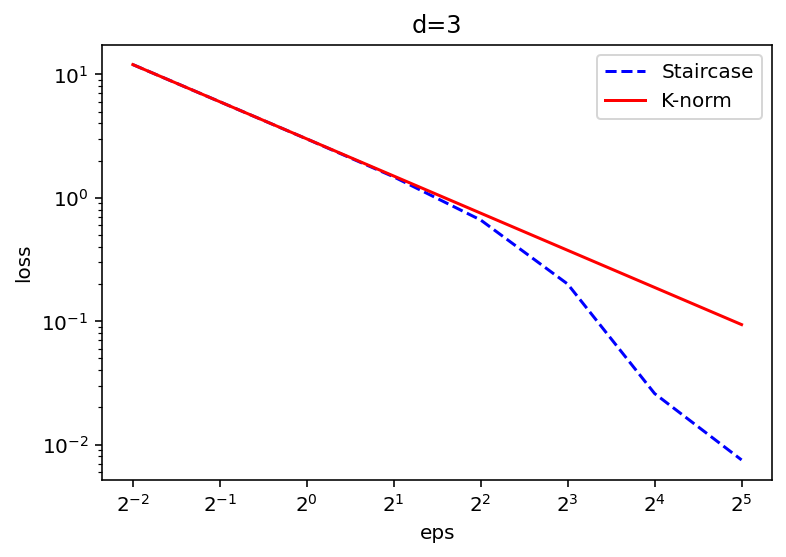

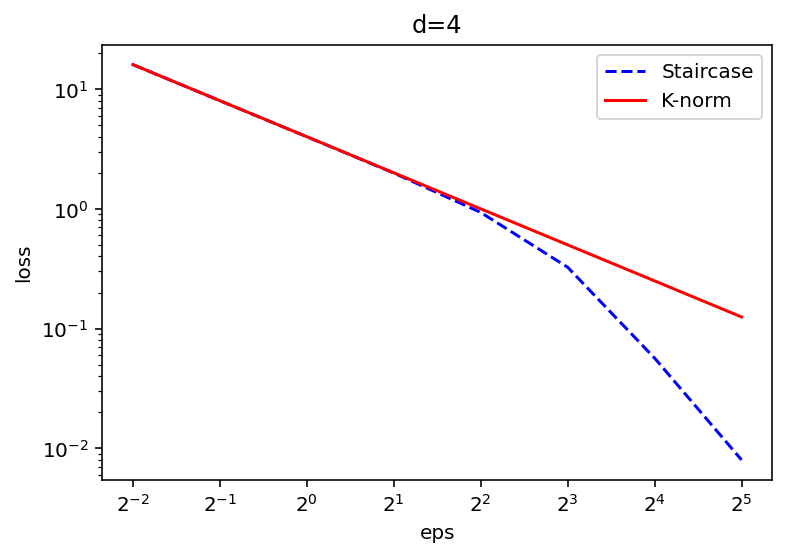

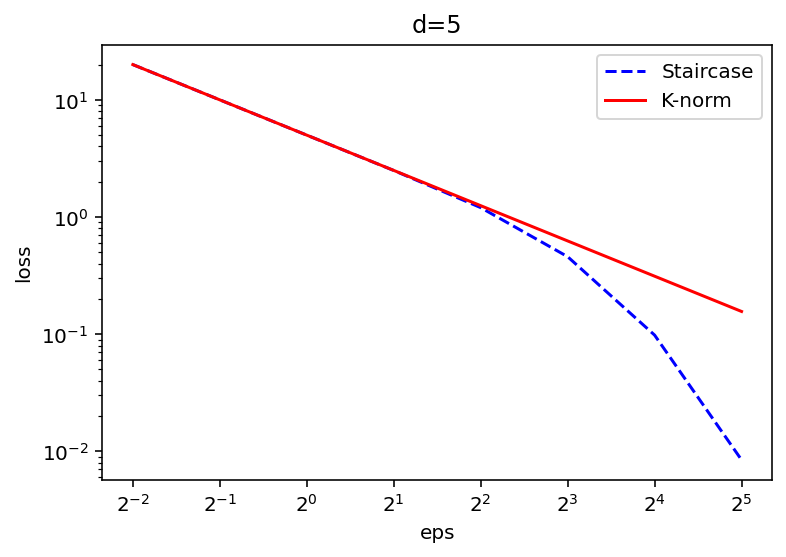

In [ ]:
for i, d in enumerate(dims):
  plt.figure(i)
  plt.xscale("log", base=2)
  plt.yscale("log")
  plt.xlabel("eps")
  plt.ylabel("loss")
  plt.plot(eps_list, discrete_errors[i], color="blue", linestyle="dashed", label="Staircase")
  plt.plot(eps_list, continuous_errors[i], color="red", linestyle="solid", label="K-norm")
  plt.title("d=%d" % d)
  plt.legend()

plt.show()


Generalized staircase mechanism's error v.s. that of vanilla K-norm, when measured using the matching target norm $\| \cdot \|_K$ (this value is independent of K), as number of dimension, $d$, changes:

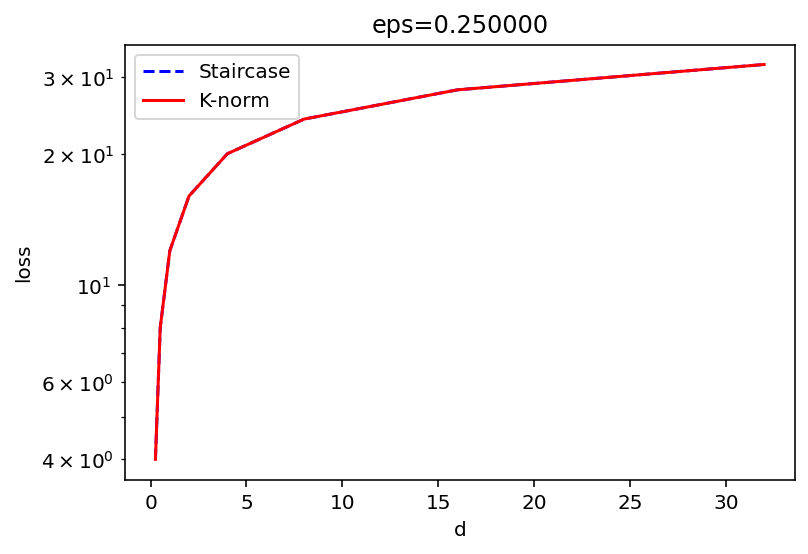

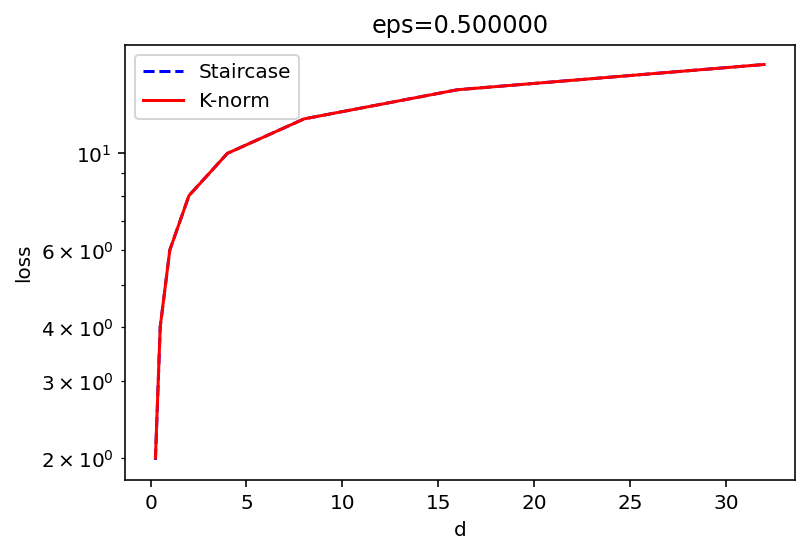

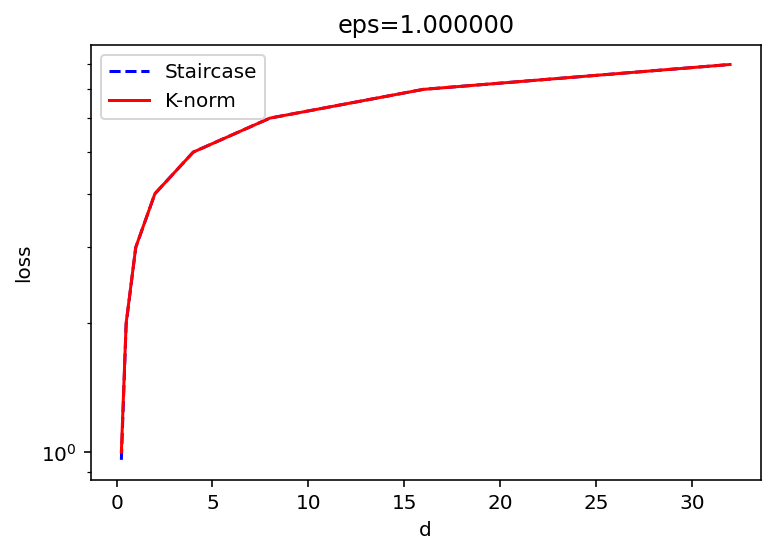

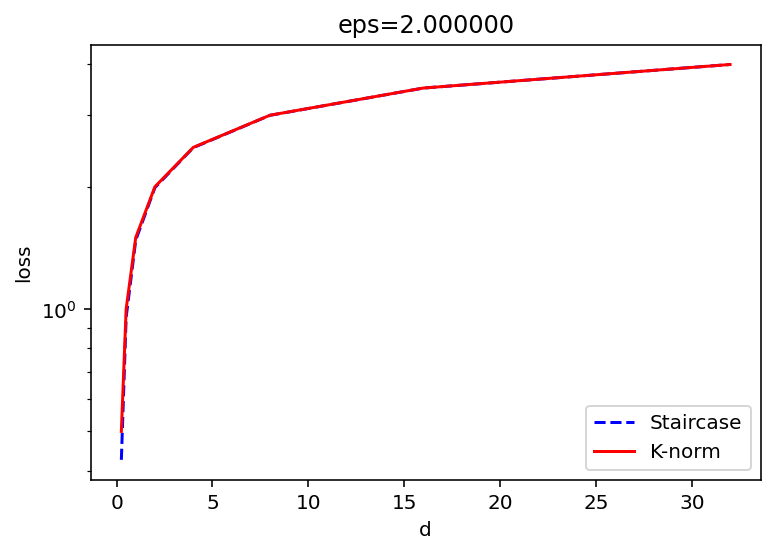

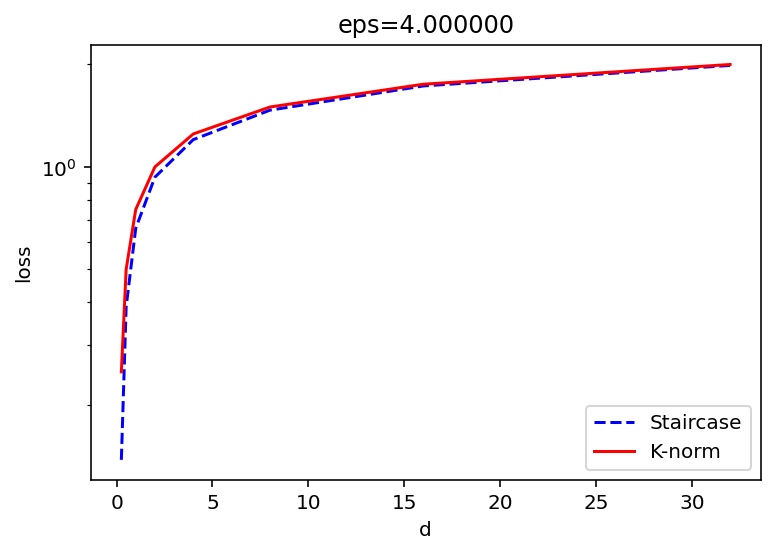

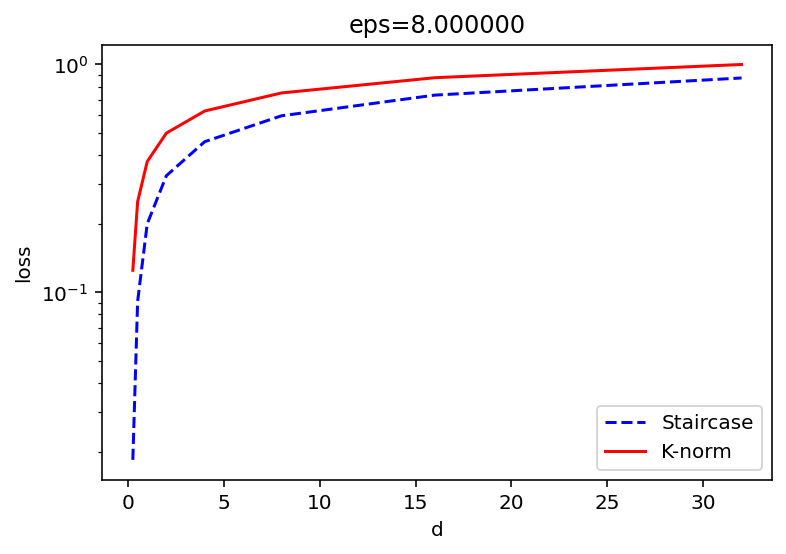

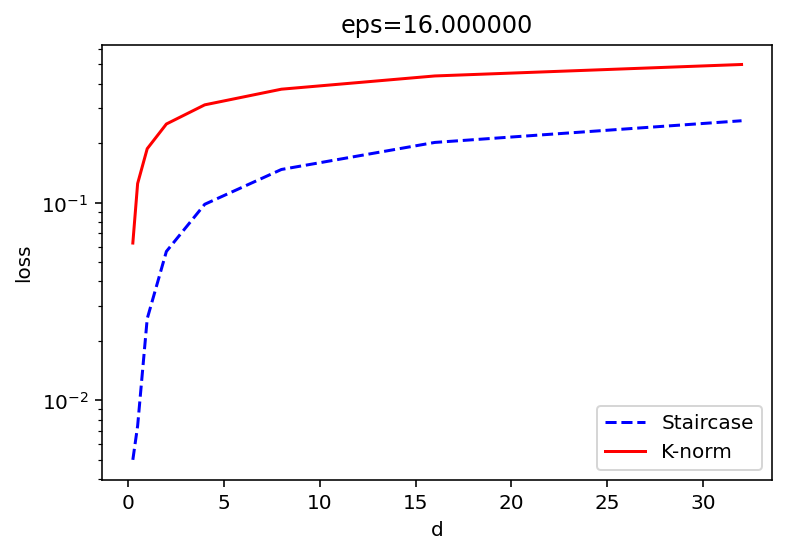

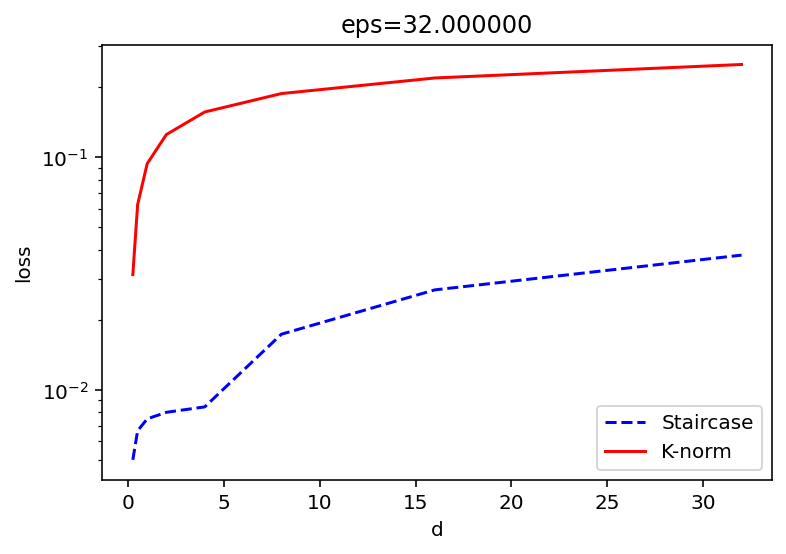

In [ ]:
plt.clf()
for j, eps in enumerate(eps_list):
  plt.figure(j)
  plt.yscale("log")
  plt.xlabel("d")
  plt.ylabel("loss")
  plt.plot(eps_list, discrete_errors[:, j], color="blue", linestyle="dashed", label="Staircase")
  plt.plot(eps_list, continuous_errors[:, j], color="red", linestyle="solid", label="K-norm")
  plt.title("eps=%f" % eps)
  plt.legend()

plt.show()

How $\gamma^*$ changes with number of dimensions $d$:

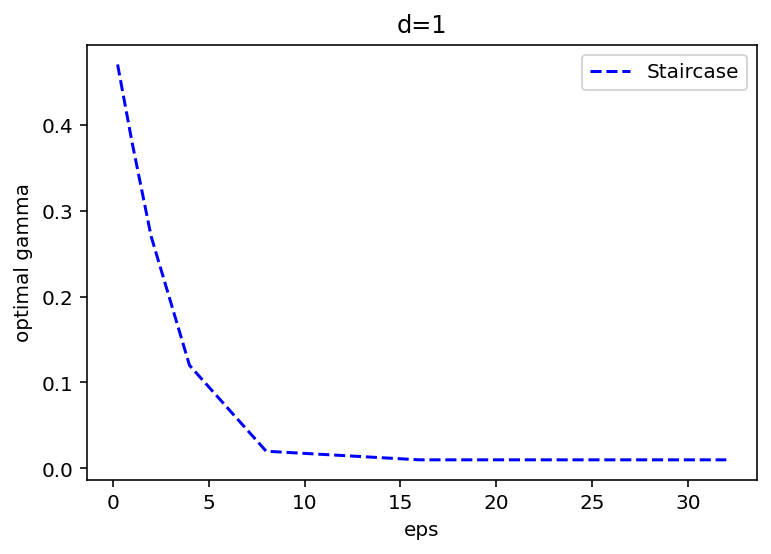

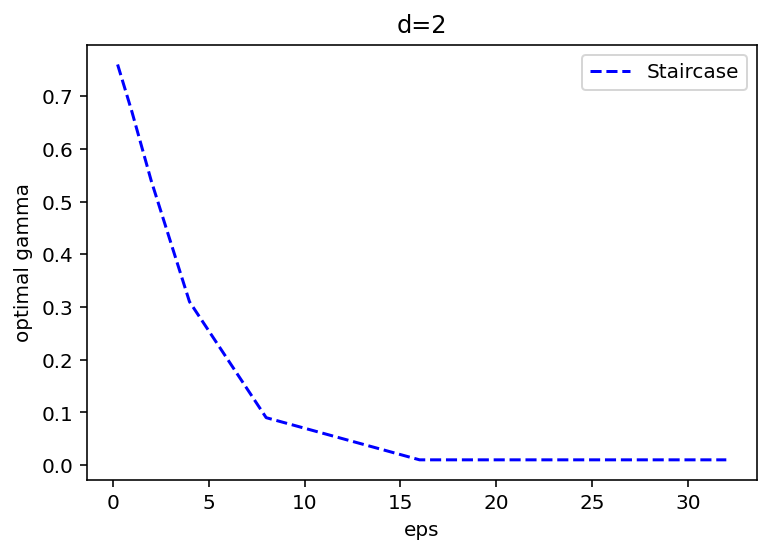

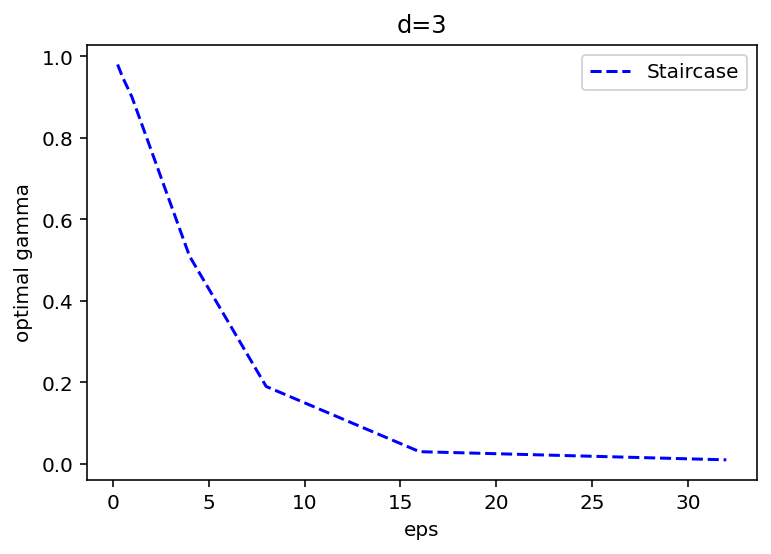

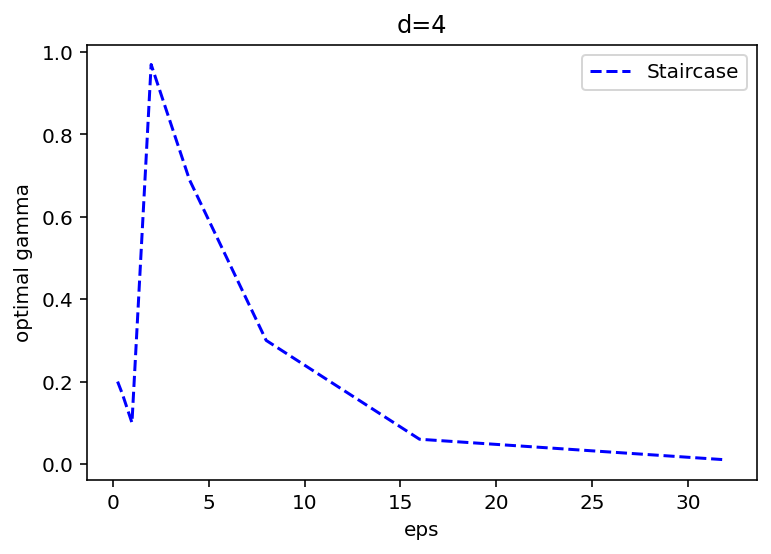

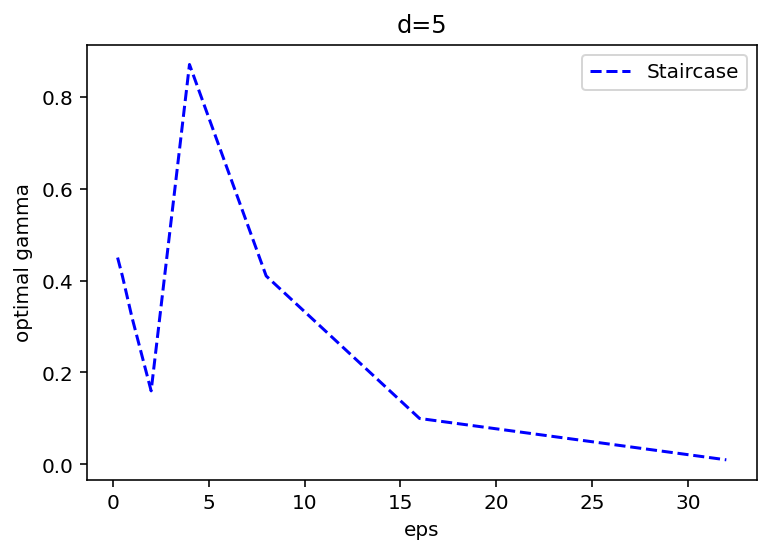

In [ ]:
for i, d in enumerate(dims):
  plt.figure(i)
  plt.xlabel("eps")
  plt.ylabel("optimal gamma")
  plt.plot(eps_list, gamma_list[i], color="blue", linestyle="dashed", label="Staircase")
  plt.title("d=%d" % d)
  plt.legend()

plt.show()



In [ ]:
eps = 4.0
dim_list = [1, 2, 3, 4, 5, 6, 7, 8]
gamma_list, discrete_errors, continuous_errors = [], [], []
for d in dim_list:
  print("dimensions: ", d)
  print("Discrete: ")
  gamma_s = ComputeOptimalGamma(d, eps, method="grid")
  gamma_list.append(gamma_s)

  discrete_error = ComputeError(gamma_s, d, eps)
  discrete_errors.append(discrete_error)
  print("Discrete: ", discrete_error)

  print("Continuous: ")
  continuous_errors.append(float(d / eps))
  print(float(d / eps))

dimensions:  1
Discrete: 
Discrete:  0.1378625734049228
Continuous: 
0.25
dimensions:  2
Discrete: 
Discrete:  0.38814350600831893
Continuous: 
0.5
dimensions:  3
Discrete: 
Discrete:  0.6601173636154078
Continuous: 
0.75
dimensions:  4
Discrete: 
Discrete:  0.93328629940805
Continuous: 
1.0
dimensions:  5
Discrete: 
Discrete:  1.202941263692098
Continuous: 
1.25
dimensions:  6
Discrete: 
Discrete:  1.4683308333535718
Continuous: 
1.5
dimensions:  7
Discrete: 
Discrete:  1.7297025310937564
Continuous: 
1.75
dimensions:  8
Discrete: 
Discrete:  1.98746617918577
Continuous: 
2.0


'1IUCS69Y3WXCcUADNMtL0d44pe5m_NafN'

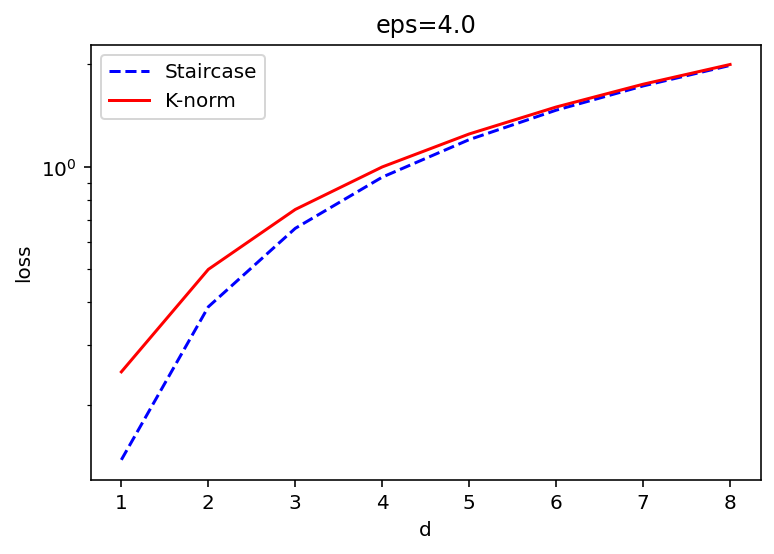

In [ ]:
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("loss")
plt.plot(dim_list, discrete_errors, color="blue", linestyle="dashed", label="Staircase")
plt.plot(dim_list, continuous_errors, color="red", linestyle="solid", label="K-norm")
plt.title(f"eps={eps}")
plt.legend()


For each one of $\ell_{1,2,\inf}$ norms, choose $K$ to be its unit norm ball, and use all of $\ell_{1,2,\inf}$ metrics to measure the expected error.

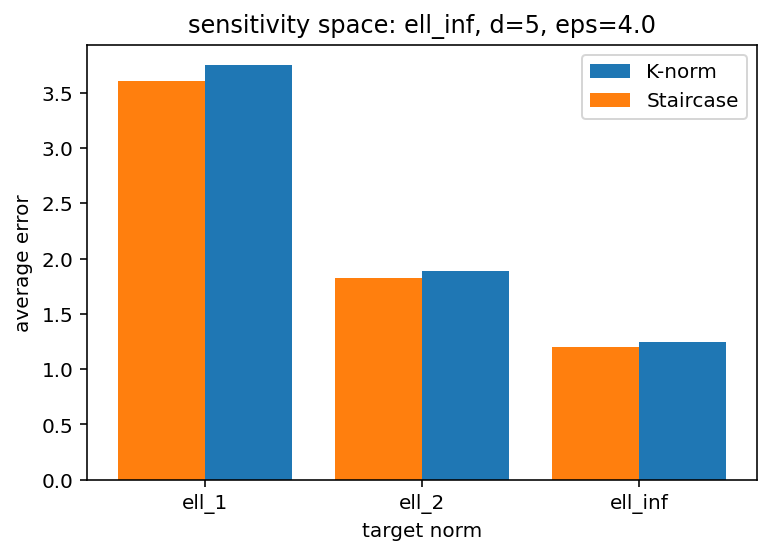

In [ ]:
ell_norms = ["ell_1", "ell_2", "ell_inf"]
num_trials = 100000
scenarios = [(3, 4.0), (4, 4.0), (5, 4.0)]
X_axis = np.arange(len(ell_norms))

for d, eps in scenarios:
  gamma_star = ComputeOptimalGamma(d, eps, method="grid")
  discrete_errors = np.zeros((len(ell_norms), len(ell_norms)))
  continuous_errors = np.zeros((len(ell_norms), len(ell_norms)))

  for i, norm_type in enumerate(ell_norms):
    discrete_samples = [DiscreteKNorm(d, eps, gamma_star, norm_type) for _ in range(num_trials)]
    continuous_samples = [ContinuousKNorm(d, eps, norm_type) for _ in range(num_trials)]
    for j, target_norm in enumerate(ell_norms):
      discrete_errors[i][j] = np.mean([MetricEval(x, target_norm) for x in discrete_samples])
      continuous_errors[i][j] = np.mean([MetricEval(x, target_norm) for x in continuous_samples])

    plt.clf()
    plt.bar(X_axis + 0.2, continuous_errors[i], 0.4, label = 'K-norm')
    plt.bar(X_axis - 0.2, discrete_errors[i], 0.4, label = 'Staircase')

    plt.xticks(X_axis, ell_norms)
    plt.xlabel("target norm")
    plt.ylabel("average error")
    plt.title(f"sensitivity space: {ell_norms[i]}, d={d}, eps={eps}")
    plt.legend()
    figure_name = f"norm_type={norm_type}_d={d}_eps={eps}.pdf"
    plt.savefig(figure_name)



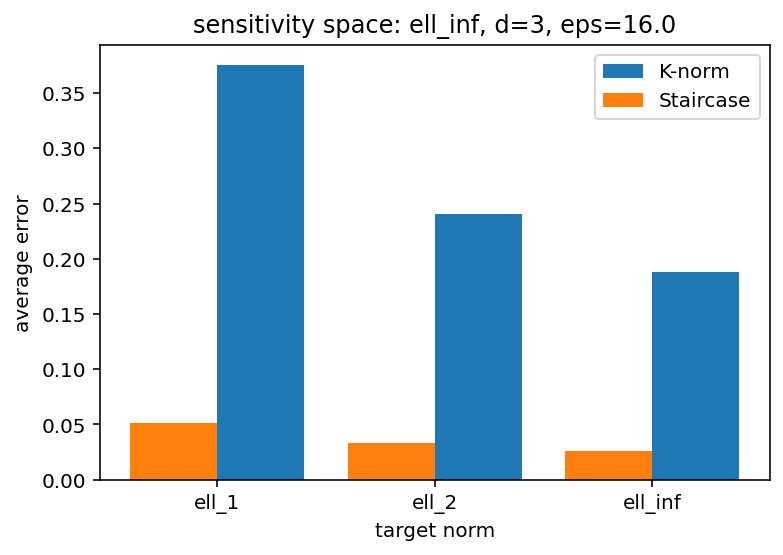

In [ ]:
ell_norms = ["ell_1", "ell_2", "ell_inf"]
num_trials = 100000
scenarios = [(3, 1.0), (3, 4.0), (3, 16.0)]
X_axis = np.arange(len(ell_norms))

for d, eps in scenarios:
  gamma_star = ComputeOptimalGamma(d, eps, method="grid")
  discrete_errors = np.zeros((len(ell_norms), len(ell_norms)))
  continuous_errors = np.zeros((len(ell_norms), len(ell_norms)))

  for i, norm_type in enumerate(ell_norms):
    discrete_samples = [DiscreteKNorm(d, eps, gamma_star, norm_type) for _ in range(num_trials)]
    continuous_samples = [ContinuousKNorm(d, eps, norm_type) for _ in range(num_trials)]
    for j, target_norm in enumerate(ell_norms):
      discrete_errors[i][j] = np.mean([MetricEval(x, target_norm) for x in discrete_samples])
      continuous_errors[i][j] = np.mean([MetricEval(x, target_norm) for x in continuous_samples])

    plt.clf()
    plt.bar(X_axis + 0.2, continuous_errors[i], 0.4, label = 'K-norm')
    plt.bar(X_axis - 0.2, discrete_errors[i], 0.4, label = 'Staircase')

    plt.xticks(X_axis, ell_norms)
    plt.xlabel("target norm")
    plt.ylabel("average error")
    plt.title(f"sensitivity space: {ell_norms[i]}, d={d}, eps={eps}")
    plt.legend()
    figure_name = f"norm_type={norm_type}_d={d}_eps={eps}.pdf"
    plt.savefig(figure_name)



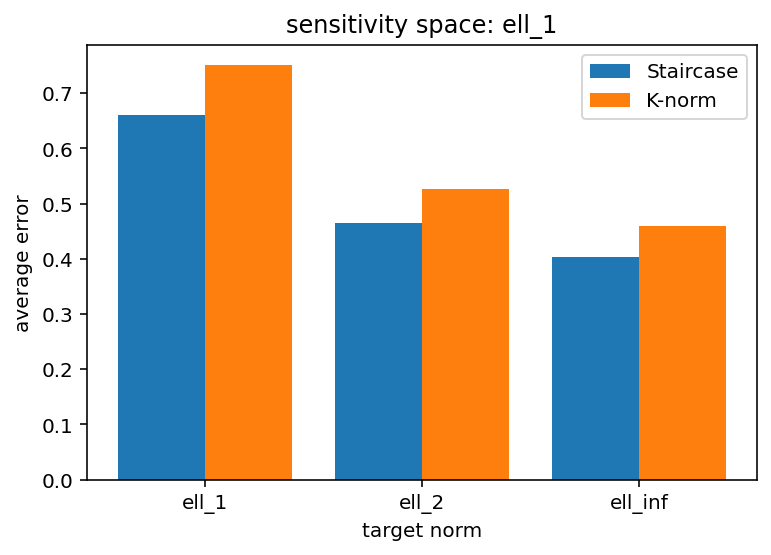

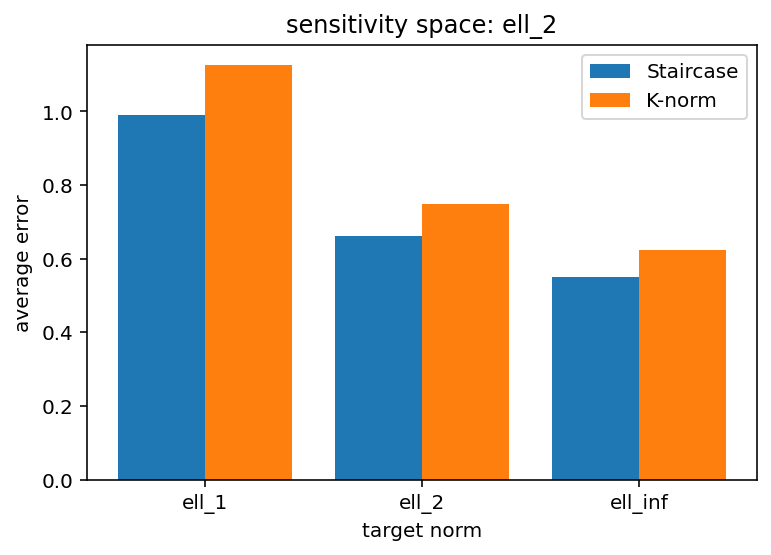

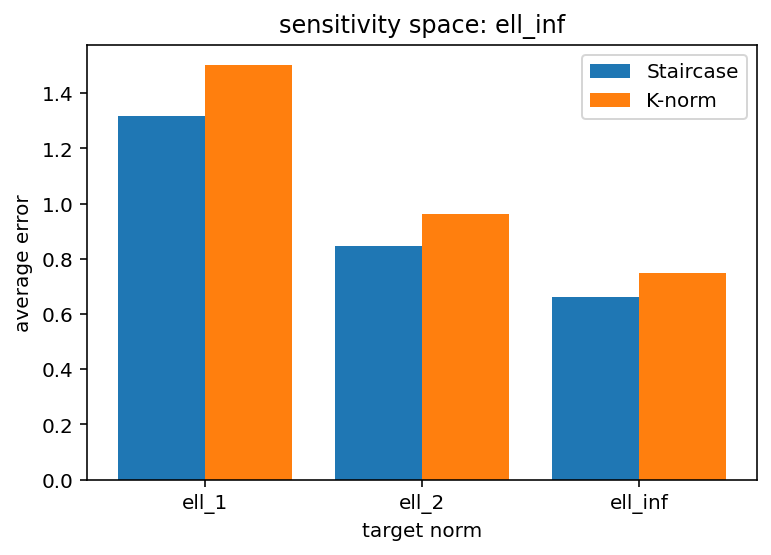

In [ ]:
X_axis = np.arange(len(ell_norms))

for i, norm_type in enumerate(ell_norms):
  plt.figure(i)
  plt.bar(X_axis - 0.2, discrete_errors[i], 0.4, label = 'Staircase')
  plt.bar(X_axis + 0.2, continuous_errors[i], 0.4, label = 'K-norm')

  plt.xticks(X_axis, ell_norms)
  plt.xlabel("target norm")
  plt.ylabel("average error")
  plt.title(f"sensitivity space: {ell_norms[i]}")
  plt.legend()
  figure_name = f"norm_type={norm_type}.pdf"
  plt.savefig(figure_name)

testing robustness of performance against different choices of $gamma$...

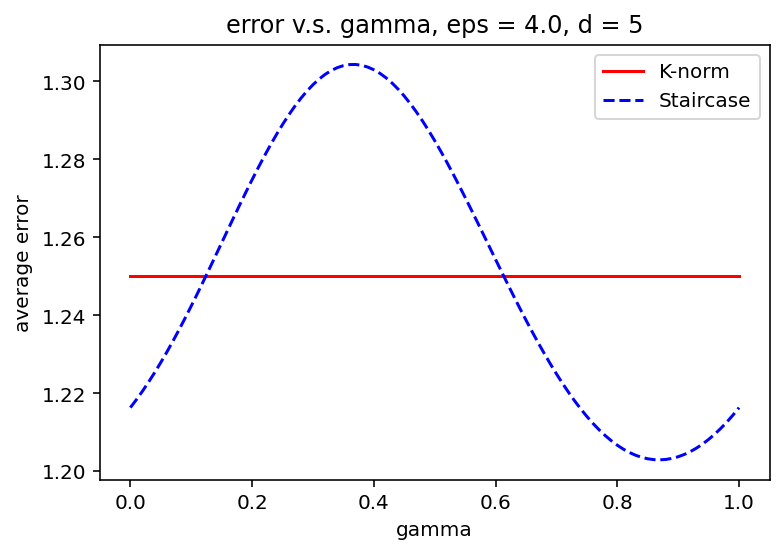

In [ ]:
scenarios = [(3, 4.0), (4, 4.0), (5, 4.0)]
gamma_list = np.linspace(0, 1, 101)
for d, eps in scenarios:
  discrete_errors = [ComputeError(gamma, d, eps) for gamma in gamma_list]
  continuous_errors = [float(d / eps)] * len(gamma_list)
  plt.clf()
  plt.xlabel("gamma")
  plt.ylabel("average error")
  plt.title(f"error v.s. gamma, eps = {eps}, d = {d}")
  plt.plot(gamma_list, continuous_errors, color="red", linestyle="solid", label="K-norm")
  plt.plot(gamma_list, discrete_errors, color="blue", linestyle="dashed", label="Staircase")
  plt.legend()
  figure_name = f"error_gamma_eps={eps},d={d}.pdf"
  plt.savefig(figure_name)

## Non-conventional K-shapes
Testing the problem construction described in the paper "Some constructions of private, efficient, and optimal k-norm and elliptic gaussian noise", by Joseph and Yu [2024].

In [ ]:
"""Private lp mechanism."""

import numpy as np
from scipy import stats


def random_signs(vector):
  """Returns vector with each coordinate's sign randomly set.

  Args:
    vector: Numpy array whose signs should be randomly set.
  """
  signs = -np.random.randint(2, size=len(vector)) * 2 + 1
  return signs * vector


def sample_lp_ball(d, p):
  """Returns a uniform random sample from the d-dimensional unit lp ball.

  Args:
    d: Integer dimension of the ball.
    p: Choice of lp norm. This can be any float p >= 1 or p = np.inf.

  Returns:
    A uniform random sample from the desired lp ball using Theorem 1 in
    https://arxiv.org/abs/math/0503650.
  """
  if p == np.inf:
    return np.random.uniform(-1, 1, size=d)
  else:
    # With the given parameters, gamma_samples are sampled from a distribution
    # with density proportional to x^(ca-1) * exp(-|x|^c) = exp(-|x|^p).
    gamma_samples = random_signs(stats.gengamma.rvs(a=1 / p, c=p, size=d))
  exponential_sample = np.random.exponential(scale=1)
  return gamma_samples / (
      np.sum(np.power(np.abs(gamma_samples), p)) + exponential_sample
  ) ** (1 / p)


def lp_mechanism(vector, p, lp_sensitivity, epsilon):
  """Returns a sample from the lp norm mechanism.

  Args:
    vector: The output will be a noisy version of Numpy array vector.
    p: Choice of lp norm. This can be any float p >= 1 or p = np.inf.
    lp_sensitivity: The statistic sensitivity, as a float, with respect to the
      chosen lp norm.
    epsilon: The output will be epsilon-DP for float epsilon.

  Returns:
    A sample from the K-norm mechanism instantiated with the specified lp norm,
    as described in Section 4 of https://arxiv.org/abs/0907.3754. Translated to
    our setting, we use vector = Fx and K = B_p^d. Note that their proof uses
    sensitivity 1.
  """
  d = len(vector)
  radius = np.random.gamma(shape=d + 1, scale=1 / epsilon)
  sample = lp_sensitivity * sample_lp_ball(d, p)
  noise = radius * sample
  return vector + noise

In [ ]:
"""Induced norm sum mechanism."""
def compute_eulerian_numbers(d):
  """Returns A where A[i, j] = Eulerian number A(i, j).

  Args:
    d: Integer such that the returned matrix has d+1 rows and columns.
  """
  eulerian_numbers = np.zeros((d + 1, d + 1))
  eulerian_numbers[:, 0] = np.ones(d + 1)
  for row in range(2, d + 1):
    for k in range(1, row + 1):
      eulerian_numbers[row, k] = (row - k) * eulerian_numbers[
          row - 1, k - 1
      ] + (k + 1) * eulerian_numbers[row - 1, k]
  return eulerian_numbers


def compute_add_ascent_indices(eulerian_numbers, k):
  """Returns array where array[i] = 1 <==> i + 1 adds an ascent when inserted.

  Args:
    eulerian_numbers: Pre-computed ndarray of Eulerian numbers, of size at least
      (k + 1) x (k + 1).
    k: Integer number of ascents.

  Returns:
    An array specifying the values which add an ascent upon insertion when
    iteratively constructing a permutation in S_d. For example, [0, 1, 1, 0]
    means that 2 and 3 add ascents when inserted, and this corresponds to
    permutations (4123), (1423), and (1243).
  """
  d = len(eulerian_numbers) - 1
  add_ascents = np.zeros(d)
  current_k = k
  for current_d in range(1, d + 1)[::-1]:
    left_mass = (current_d - current_k) * eulerian_numbers[
        current_d - 1, current_k - 1
    ]
    right_mass = (current_k + 1) * eulerian_numbers[current_d - 1, current_k]
    if np.random.uniform() < left_mass / (left_mass + right_mass):
      add_ascents[current_d - 1] = 1
      current_k = current_k - 1
    else:
      add_ascents[current_d - 1] = 0
  return add_ascents


def sample_permutation_with_ascents(eulerian_numbers, k):
  """Returns a uniform random permutation on [d] with k ascents.

  Args:
    eulerian_numbers: Pre-computed ndarray of Eulerian numbers, of size at least
      (k + 1) x (k + 1).
    k: Integer number of ascents.
  """
  add_ascents = compute_add_ascent_indices(eulerian_numbers, k)
  d = len(add_ascents)
  permutation = np.ones(1)
  # i ranges over numbers to insert
  for i in range(2, d + 1):
    if add_ascents[i - 1]:
      insertion_options = list(
          np.where(permutation[1:] < permutation[:-1])[0] + 1
      ) + [i - 1]
    else:
      insertion_options = list(
          np.where(permutation[1:] > permutation[:-1])[0] + 1
      ) + [0]
    insert_idx = np.random.choice(insertion_options, 1)[0]
    permutation = np.insert(permutation, min(len(permutation), insert_idx), i)
  return permutation.astype(int)


def phi(x):
  """Returns phi(x), where phi is Stanley's bijection.

  Args:
    x: Float in (0, 1).

  Returns:
    phi(x), where phi is the function described on the first page of
    https://math.mit.edu/~rstan/pubs/pubfiles/34a.pdf.
  """
  d = len(x)
  new_x = np.zeros(d+1)
  new_x[1:] = x
  x_diffs = new_x[:-1] - new_x[1:]
  y = x_diffs + (x_diffs < 0)
  return y


def sample_slice_index(eulerian_numbers, k):
  """Returns a slice index of the cube, sampled proportionally to its volume.

  Args:
    eulerian_numbers: Pre-computed matrix of Eulerian numbers, of size at least
      (k + 1) x (k + 1).
    k: Integer number of ascents.
  """
  slices = eulerian_numbers[-1, :k]
  weights = slices / np.sum(slices)
  return np.random.choice(len(slices), 1, p=weights)[0]


def sample_fundamental_simplex(d):
  """Returns a uniform random sample from the fundamental simplex.

  Args:
    d: Integer dimension of the fundamental simplex.
  """
  convex_combination_weights = stats.dirichlet.rvs([1] * (d + 1))
  fundamental_simplex_vertices = np.zeros((d + 1, d))
  for i in range(1, d + 1):
    fundamental_simplex_vertices[i - 1, -i:] = 1
  return np.sum(
      np.transpose(convex_combination_weights) * fundamental_simplex_vertices,
      axis=0,
  )


def sample_sum_ball(eulerian_numbers, k):
  """Returns a uniform sample from the induced norm ball for sum.

  Args:
    eulerian_numbers: Pre-computed matrix of Eulerian numbers, of size at least
      (k + 1) x (k + 1).
    k: Integer l_0 bound.
  """
  d = len(eulerian_numbers) - 1
  slice_index = sample_slice_index(eulerian_numbers, k)
  sigma = sample_permutation_with_ascents(eulerian_numbers, slice_index)
  fundamental_simplex_sample = sample_fundamental_simplex(d)
  permuted_fundamental_simplex_sample = fundamental_simplex_sample[sigma - 1]
  return random_signs(phi(permuted_fundamental_simplex_sample))


def sum_mechanism(vector, eulerian_numbers, k, epsilon):
  """Returns a sample from the epsilon-DP induced norm mechanism for sum.

  Args:
    vector: The output will be a noisy version of Numpy array vector.
    eulerian_numbers: Pre-computed matrix of Eulerian numbers, of size at least
      (k + 1) x (k + 1).
    k: l_0 bound.
    epsilon: The output will be epsilon-DP for float epsilon. Assumes vector is
      1-sensitive with respect to the sum ball.

  Returns:
    A sample from the K-norm mechanism, as described in Section 4 of
    https://arxiv.org/abs/0907.3754, instantiated with the norm induced by sum.
  """
  d = len(vector)
  radius = np.random.gamma(shape=d + 1, scale=1 / epsilon)
  ball_sample = sample_sum_ball(eulerian_numbers, k)
  noise = radius * ball_sample
  return vector + noise

In [ ]:
def DiscreteSumMechanism(vector, eulerian_numbers, k, epsilon, gamma):
  d = len(vector)
  radius = DiscreteGammaDistribution(gamma, d, epsilon)
  ball_sample = sample_sum_ball(eulerian_numbers, k)
  noise = radius * ball_sample
  return vector + noise

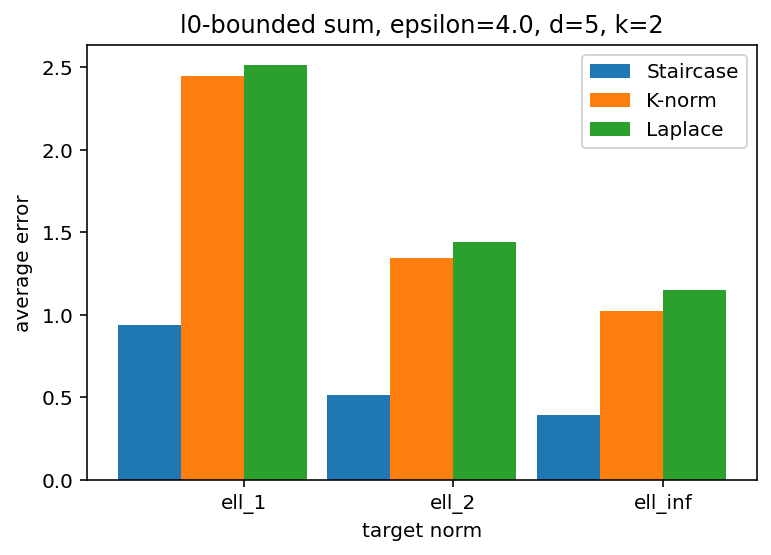

In [ ]:
"""Script for running sum simulation and saving its plot."""

scenarios = [(3, 1.0), (3, 4.0), (3, 16.0), (4, 4.0), (5, 4.0)]
l0_bound = 2
linf_bound = 1
num_trials = 10000
for d, epsilon in scenarios:
  eulerian_numbers = compute_eulerian_numbers(d)
  error_norms = [1, 2, math.inf]
  continuous_errors = np.zeros((len(error_norms), num_trials))
  discrete_errors = np.zeros((len(error_norms), num_trials))
  laplace_errors = np.zeros((len(error_norms), num_trials))

  gamma_star = ComputeOptimalGamma(d, epsilon, "grid")
  for trial in range(num_trials):
    sample = sum_mechanism(
            np.zeros(d), eulerian_numbers, l0_bound, epsilon
            )
    for i, error_norm in enumerate(error_norms):
      continuous_errors[i][trial] = np.linalg.norm(sample, ord=error_norm)

    discrete_sample = DiscreteSumMechanism(
        np.zeros(d), eulerian_numbers, l0_bound, epsilon, gamma_star
    )
    for i, error_norm in enumerate(error_norms):
      discrete_errors[i][trial] = np.linalg.norm(discrete_sample, ord=error_norm)

    laplace_sample = lp_mechanism(np.zeros(d), 1, l0_bound, epsilon)
    for i, error_norm in enumerate(error_norms):
      laplace_errors[i][trial] = np.linalg.norm(laplace_sample, ord=error_norm)

  continuous_results = np.mean(continuous_errors, axis=1)
  discrete_results = np.mean(discrete_errors, axis=1)
  laplace_results = np.mean(laplace_errors, axis=1)
  plt.clf()

  plt.bar(X_axis - 0.45, discrete_results, 0.3, label = 'Staircase')
  plt.bar(X_axis - 0.15, continuous_results, 0.3, label = 'K-norm')
  plt.bar(X_axis + 0.15, laplace_results, 0.3, label = 'Laplace')

  plt.xticks(X_axis, ell_norms)
  plt.xlabel("target norm")
  plt.ylabel("average error")
  plt.title(f"l0-bounded sum, epsilon={epsilon}, d={d}, k={l0_bound}")
  plt.legend()
  figure_name = f"l0_bounded_sum,d={d},l0_bound={l0_bound}.pdf"
  plt.savefig(figure_name)